In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

2026-01-30 17:02:11.202999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769792531.224422    1071 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769792531.230961    1071 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769792531.248172    1071 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769792531.248193    1071 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769792531.248196    1071 computation_placer.cc:177] computation placer alr

In [2]:

data_path = '/kaggle/input/big-databiopharmaceutical-manufacturing/Mendeley_data/100_Batches_IndPenSim_V3.csv'
df_raw = pd.read_csv(data_path)

variable_raman_data = np.split(df_raw, [df_raw.columns.get_loc("2400")], axis=1)
df = variable_raman_data[0].copy()

if '2-PAT control(PAT_ref:PAT ref)' in df.columns:
    df = df.rename(columns={
        '2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)',
        'Batch reference(Batch_ref:Batch ref)': '2-PAT control(PAT_ref:PAT ref)'
    })

batch_col = 'Batch reference(Batch_ref:Batch ref)'
fault_col = 'Fault reference(Fault_ref:Fault ref)'

critical_cols = ['Time (h)', 'Penicillin concentration(P:g/L)', batch_col, fault_col]
df = df.dropna(subset=critical_cols).reset_index(drop=True)

cols_to_drop = [batch_col, fault_col, 'Fault flag', 'Time (h)']
operator_cols = [col for col in df.columns if 'operator' in col.lower()]
cols_to_drop.extend(operator_cols)

all_feature_cols = [col for col in df.columns if col not in cols_to_drop]

print(f"Loaded: {len(df)} rows, {len(all_feature_cols)} features")

# Top 5 Sensors from GBT the gbt experiment
top_5_sensors = [
    'Temperature(T:K)',
    'Acid flow rate(Fa:L/h)',
    'Dissolved oxygen concentration(DO2:mg/L)',
    'pH(pH:pH)',
    'Vessel Volume(V:L)'
]

sensors_found = [s for s in top_5_sensors if s in all_feature_cols]
print(f"Using {len(sensors_found)} sensors")

Loaded: 113935 rows, 34 features
Using 5 sensors


In [3]:
def create_multi_step_sequences(
    sensor_data,
    batch_fault_info,
    seq_length=700,
    future_steps=100,
    normal_only=True,
    fault_flag_col="Fault flag",
    label_on="future", 
):
    X, y, batch_ids = [], [], []
    seq_labels = []

    all_batches = sensor_data[batch_col].unique()
    faulty_batches = set(batch_fault_info.keys())
    normal_batches = set(all_batches) - faulty_batches

    print(f"Normal batches: {len(normal_batches)}, Faulty batches: {len(faulty_batches)}")

    batches_to_use = normal_batches if normal_only else all_batches
    has_fault_flag = fault_flag_col in sensor_data.columns

    for batch_id in batches_to_use:
        batch_data = sensor_data[sensor_data[batch_col] == batch_id].copy()

        if len(batch_data) < seq_length + future_steps:
            continue

        sensor_values = batch_data[sensors_found].values
        fault_flags = batch_data[fault_flag_col].values if has_fault_flag else None

        for i in range(len(sensor_values) - seq_length - future_steps + 1):
            X.append(sensor_values[i:i + seq_length])
            y.append(sensor_values[i + seq_length:i + seq_length + future_steps])
            batch_ids.append(batch_id)

            if fault_flags is None:
                continue

            if label_on == "future":
                window = fault_flags[i + seq_length:i + seq_length + future_steps]
            elif label_on == "input":
                window = fault_flags[i:i + seq_length]
            else:
                raise ValueError("label_on must be 'future' or 'input'")

            seq_labels.append(int(np.any(np.asarray(window) > 0)))

    X = np.array(X)
    y = np.array(y)
    batch_ids = np.array(batch_ids)
    seq_labels = np.array(seq_labels, dtype=int) if has_fault_flag else None

    return X, y, batch_ids, seq_labels


seq_length = 700
future_steps = 100

fault_info = {}
for batch_id in df[batch_col].unique():
    batch_data = df[df[batch_col] == batch_id]
    if batch_data[fault_col].max() > 0:
        fault_info[batch_id] = batch_data[fault_col].max()


X_normal, y_normal, batch_ids_seq, _ = create_multi_step_sequences(
    df, fault_info, seq_length, future_steps,
    normal_only=True, fault_flag_col="Fault flag", label_on="future"
)

print(f"Created {len(X_normal)} sequences from normal batches only")
print(f"Input shape: {X_normal.shape}")
print(f"Output shape: {y_normal.shape}")



Normal batches: 90, Faulty batches: 10
Created 30500 sequences from normal batches only
Input shape: (30500, 700, 5)
Output shape: (30500, 100, 5)


In [4]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

n_samples, n_timesteps, n_features = X_normal.shape

X_scaled = scaler_X.fit_transform(X_normal.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
y_scaled = scaler_y.fit_transform(y_normal.reshape(-1, n_features)).reshape(n_samples, future_steps, n_features)

print(f"X: mean={X_scaled.mean():.4f}, std={X_scaled.std():.4f}")
print(f"y: mean={y_scaled.mean():.4f}, std={y_scaled.std():.4f}")


X: mean=0.0000, std=1.0000
y: mean=-0.0000, std=1.0000


In [5]:

unique_normal_batches = np.unique(batch_ids_seq)

train_size = int(0.7 * len(unique_normal_batches))
val_size = int(0.2 * len(unique_normal_batches))

train_batches = unique_normal_batches[:train_size]
val_batches = unique_normal_batches[train_size:train_size + val_size]
test_batches = unique_normal_batches[train_size + val_size:]

train_mask = np.isin(batch_ids_seq, train_batches)
val_mask = np.isin(batch_ids_seq, val_batches)
test_mask = np.isin(batch_ids_seq, test_batches)

X_train, y_train = X_scaled[train_mask], y_scaled[train_mask]
X_val, y_val = X_scaled[val_mask], y_scaled[val_mask]
X_test, y_test = X_scaled[test_mask], y_scaled[test_mask]

print(f"Train: {len(X_train)} sequences from {len(train_batches)} batches")
print(f"Val: {len(X_val)} sequences from {len(val_batches)} batches")
print(f"Test: {len(X_test)} sequences from {len(test_batches)} batches")

Train: 21527 sequences from 62 batches
Val: 5643 sequences from 18 batches
Test: 3330 sequences from 10 batches


In [6]:

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, 
         input_shape=(seq_length, len(sensors_found))),
    Dropout(0.25),
    
    LSTM(128, activation='tanh', return_sequences=False),
    Dropout(0.25),
    
    Dense(future_steps * len(sensors_found))
], name='Sensor_Prediction_LSTM')


def reshape_output(x):
    return tf.reshape(x, (-1, future_steps, len(sensors_found)))

model.add(layers.Lambda(reshape_output))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.Huber(delta=1.0),
    metrics=['mae']
)

model.summary()


early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


print(f"\nTraining completed: {len(history.history['loss'])} epochs")
print(f"Available metrics: {list(history.history.keys())}")

I0000 00:00:1769792581.642927    1071 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769792581.648122    1071 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "Sensor_Prediction_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 700, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │        64,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100, 5)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,692 (1.01 MB)

 Trainable params: 264,692 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1769792585.637654    1132 cuda_dnn.cc:529] Loaded cuDNN version 91002


337/337 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.3032 - mae: 0.5854 - val_loss: 0.1519 - val_mae: 0.3901 - learning_rate: 1.0000e-04
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.2252 - mae: 0.4773 - val_loss: 0.1320 - val_mae: 0.3672 - learning_rate: 1.0000e-04
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.2101 - mae: 0.4533 - val_loss: 0.1140 - val_mae: 0.3366 - learning_rate: 1.0000e-04
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.1943 - mae: 0.4277 - val_loss: 0.1130 - val_mae: 0.3340 - learning_rate: 1.0000e-04
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.1868 - mae: 0.4120 - val_loss: 0.1045 - val_mae: 0.3166 - learning_rate: 1.0000e-04
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.1810 - mae: 0.4015 - val_loss: 0.1027 - val_mae: 0.3125 - learning_rate: 1.0000e-04
Epoch 7/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.1765 - mae: 0.3933 - val_loss: 0.1008 - val_mae: 0.30

In [7]:

y_pred_scaled = model.predict(X_test, verbose=0)


y_pred_flat = y_pred_scaled.reshape(-1, len(sensors_found))
y_pred = scaler_y.inverse_transform(y_pred_flat).reshape(-1, future_steps, len(sensors_found))

y_test_flat = y_test.reshape(-1, len(sensors_found))
y_test_actual = scaler_y.inverse_transform(y_test_flat).reshape(-1, future_steps, len(sensors_found))

mae = np.mean(np.abs(y_pred - y_test_actual))
rmse = np.sqrt(np.mean((y_pred - y_test_actual)**2))

print(f"\nTest Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Test Performance:
MAE: 130.4955
RMSE: 395.7539


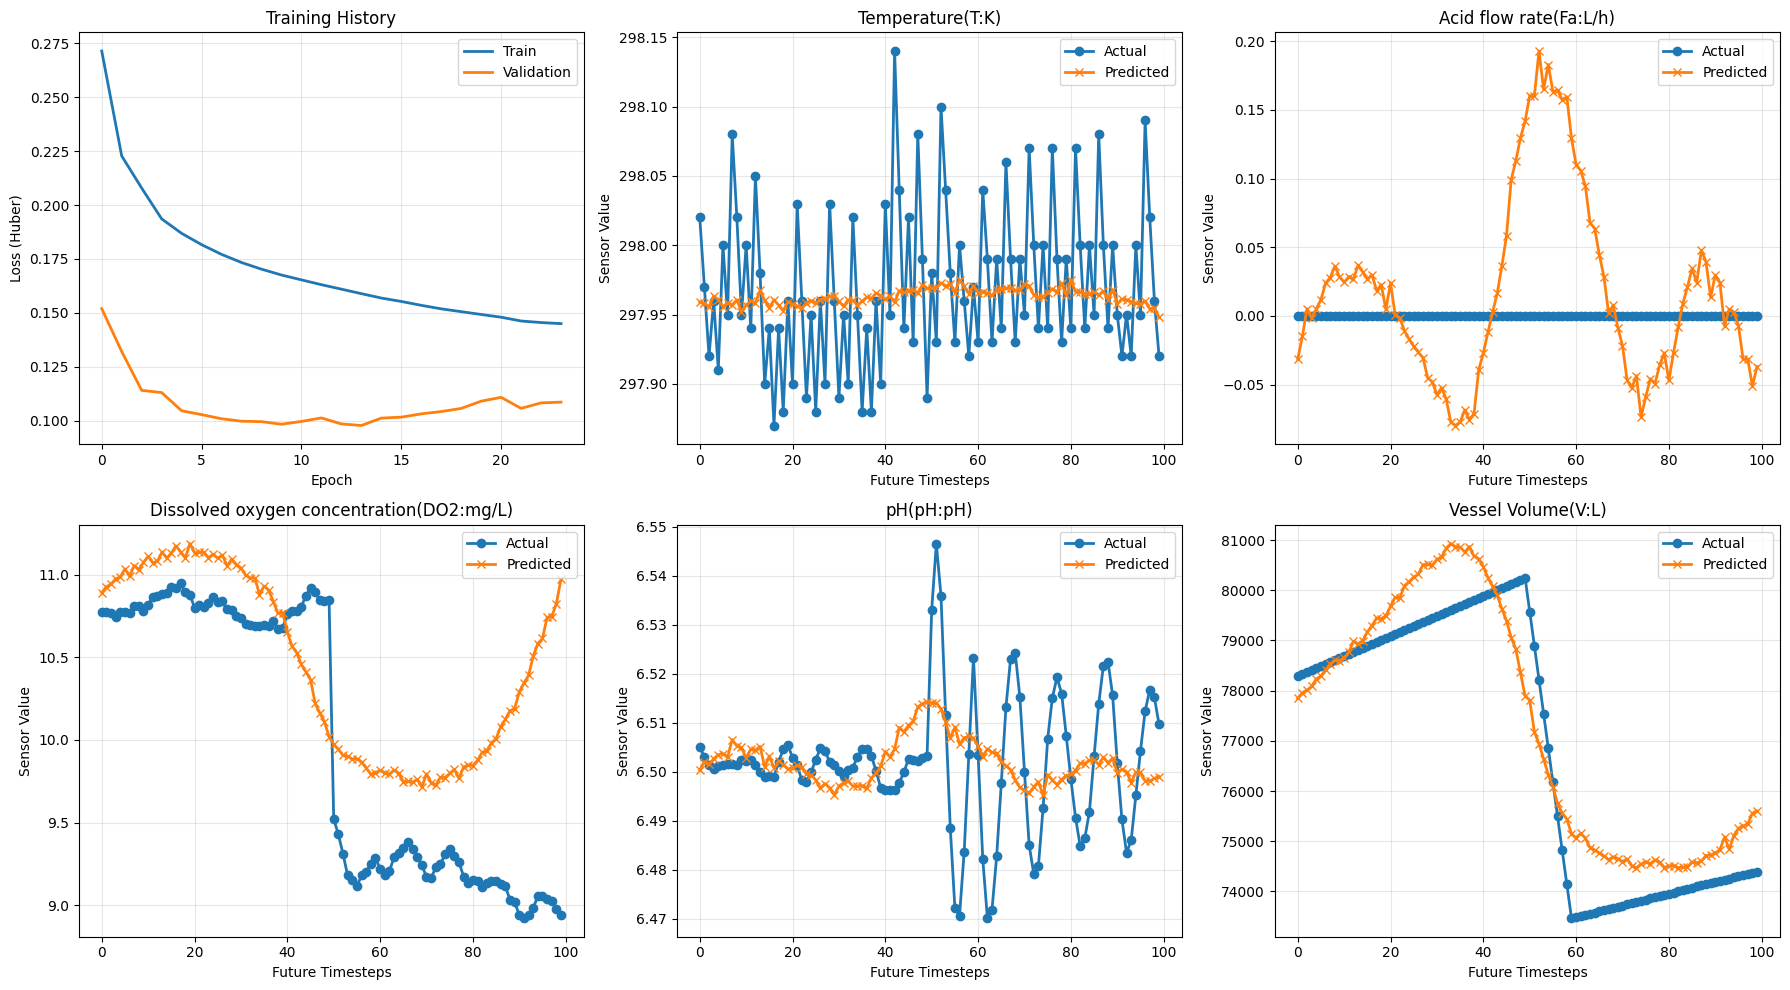

In [8]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))


ax = axes[0, 0]
ax.plot(history.history['loss'], label='Train', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Huber)')
ax.set_title('Training History')
ax.legend()
ax.grid(alpha=0.3)


sample_idx = 0
for i, sensor_name in enumerate(sensors_found):
    row = (i + 1) // 3
    col = (i + 1) % 3
    ax = axes[row, col]
    
    ax.plot(range(future_steps), y_test_actual[sample_idx, :, i], 
            marker='o', label='Actual', linewidth=2)
    ax.plot(range(future_steps), y_pred[sample_idx, :, i], 
            marker='x', label='Predicted', linewidth=2)
    ax.set_xlabel('Future Timesteps')
    ax.set_ylabel('Sensor Value')
    ax.set_title(sensor_name)
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

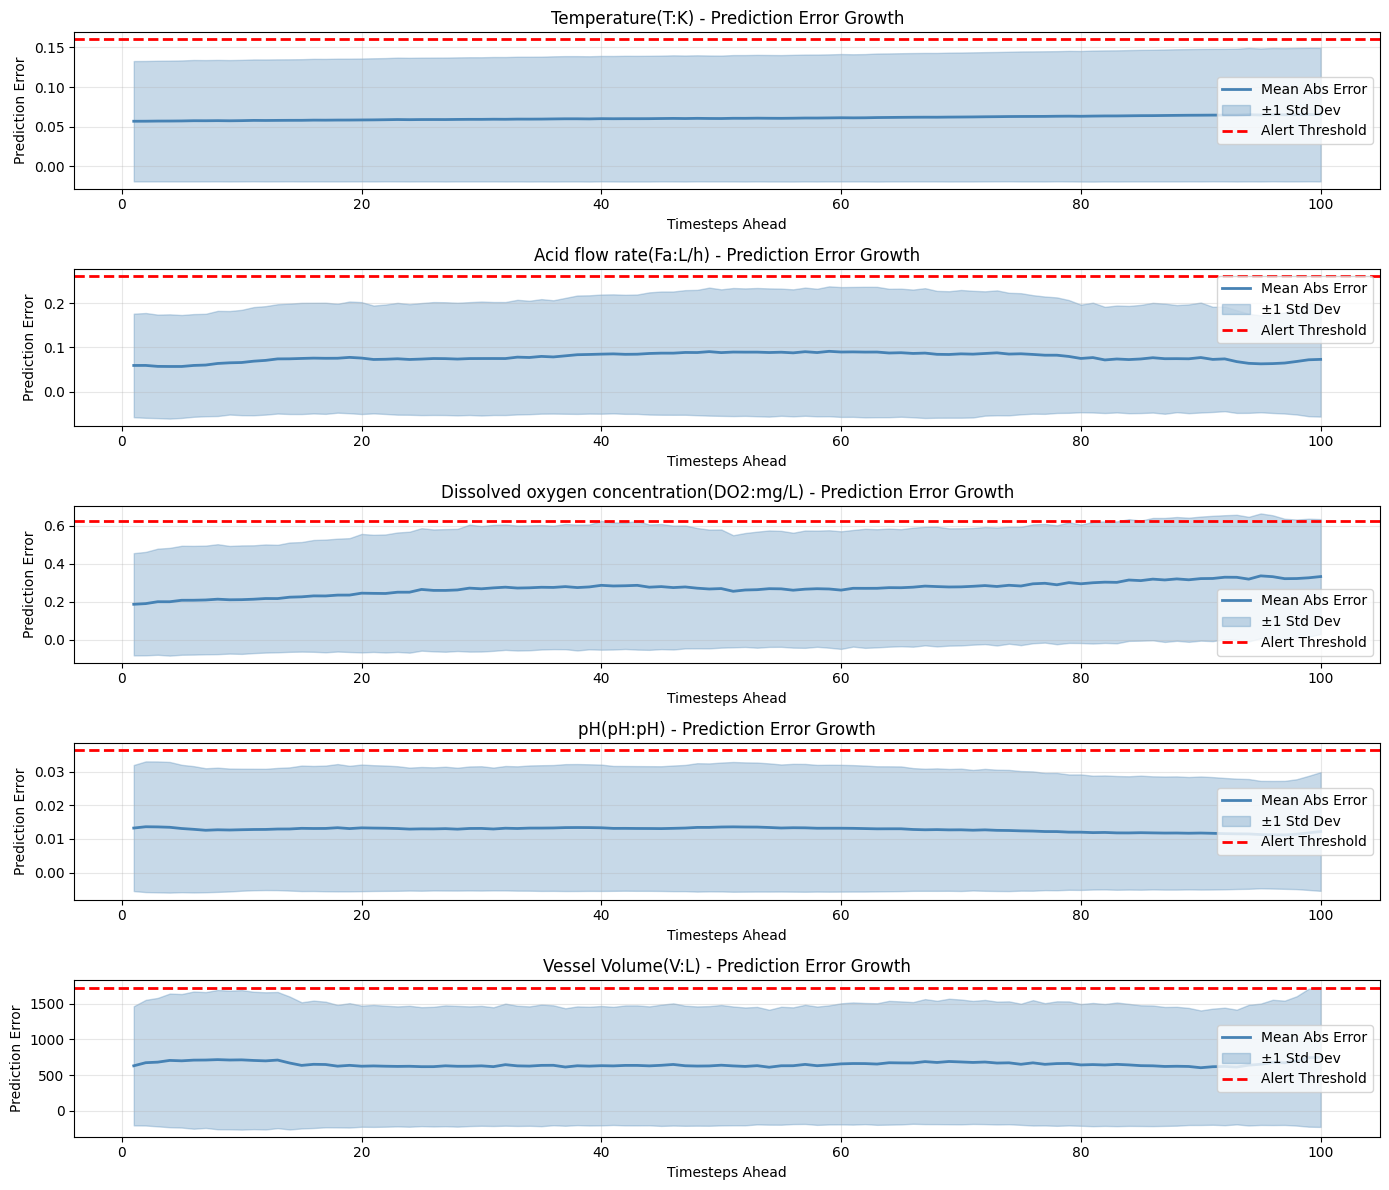

In [9]:

deviation_threshold = 2.0 

fig, axes = plt.subplots(len(sensors_found), 1, figsize=(14, 12))

for i, sensor_name in enumerate(sensors_found):
    ax = axes[i]
    
   
    errors = y_pred[:, :, i] - y_test_actual[:, :, i]
    

    mean_abs_dev = np.mean(np.abs(errors), axis=0)
    std_dev = np.std(errors, axis=0)
    
    timesteps = range(1, future_steps + 1)
    
    ax.plot(timesteps, mean_abs_dev, linewidth=2, color='steelblue', label='Mean Abs Error')
    ax.fill_between(timesteps, 
                     mean_abs_dev - std_dev, 
                     mean_abs_dev + std_dev, 
                     alpha=0.3, color='steelblue', label='±1 Std Dev')
    ax.axhline(deviation_threshold * np.mean(std_dev), 
               color='red', linestyle='--', linewidth=2, label='Alert Threshold')
    
    ax.set_xlabel('Timesteps Ahead')
    ax.set_ylabel('Prediction Error')
    ax.set_title(f'{sensor_name} - Prediction Error Growth')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:

for sensor_idx, sensor_name in enumerate(sensors_found):
    errors = np.abs(y_pred[:, :, sensor_idx] - y_test_actual[:, :, sensor_idx])
    
    threshold = deviation_threshold * np.std(errors)
    
    early_warnings = []
    for sample_errors in errors:
        exceeds = np.where(sample_errors > threshold)[0]
        if len(exceeds) > 0:
            early_warnings.append(exceeds[0] + 1) 
    
    if len(early_warnings) > 0:
        avg_warning_time = np.mean(early_warnings)
        print(f"\n{sensor_name}:")
        print(f"  Average early warning: {avg_warning_time:.1f} timesteps ahead")
        print(f"  Detection rate: {len(early_warnings)/len(errors)*100:.1f}%")
    else:
        print(f"\n{sensor_name}: No anomalies detected above threshold")



Temperature(T:K):
  Average early warning: 14.0 timesteps ahead
  Detection rate: 99.6%

Acid flow rate(Fa:L/h):
  Average early warning: 45.5 timesteps ahead
  Detection rate: 77.8%

Dissolved oxygen concentration(DO2:mg/L):
  Average early warning: 25.2 timesteps ahead
  Detection rate: 65.9%

pH(pH:pH):
  Average early warning: 31.1 timesteps ahead
  Detection rate: 100.0%

Vessel Volume(V:L):
  Average early warning: 32.1 timesteps ahead
  Detection rate: 100.0%


In [11]:

X_faulty, y_faulty, batch_ids_faulty, _ = create_multi_step_sequences(
    df, fault_info, seq_length, future_steps, normal_only=False
)


faulty_batch_set = set(fault_info.keys())
faulty_mask = np.isin(batch_ids_faulty, list(faulty_batch_set))

X_faulty_test = X_faulty[faulty_mask]
y_faulty_test = y_faulty[faulty_mask]
batch_ids_faulty_test = batch_ids_faulty[faulty_mask]

print(f"Faulty sequences: {len(X_faulty_test)} from {len(np.unique(batch_ids_faulty_test))} batches")


X_faulty_flat = X_faulty_test.reshape(-1, len(sensors_found))
X_faulty_scaled_flat = scaler_X.transform(X_faulty_flat)  
X_faulty_scaled = X_faulty_scaled_flat.reshape(len(X_faulty_test), seq_length, len(sensors_found))

y_faulty_flat = y_faulty_test.reshape(-1, len(sensors_found))
y_faulty_scaled_flat = scaler_y.transform(y_faulty_flat)
y_faulty_scaled = y_faulty_scaled_flat.reshape(len(X_faulty_test), future_steps, len(sensors_found))

Normal batches: 90, Faulty batches: 10
Faulty sequences: 3535 from 10 batches


In [12]:



y_pred_faulty_scaled = model.predict(X_faulty_scaled, verbose=0)


y_pred_faulty_flat = y_pred_faulty_scaled.reshape(-1, len(sensors_found))
y_pred_faulty = scaler_y.inverse_transform(y_pred_faulty_flat).reshape(-1, future_steps, len(sensors_found))

y_faulty_actual_flat = y_faulty_scaled.reshape(-1, len(sensors_found))
y_faulty_actual = scaler_y.inverse_transform(y_faulty_actual_flat).reshape(-1, future_steps, len(sensors_found))


anomaly_scores = np.abs(y_pred_faulty - y_faulty_actual)

print("\nAnomaly Scores by Sensor:")
for i, sensor_name in enumerate(sensors_found):
    sensor_anomalies = anomaly_scores[:, :, i]
    mean_anomaly = np.mean(sensor_anomalies)
    max_anomaly = np.max(sensor_anomalies)
    
    print(f"\n{sensor_name}:")
    print(f"  Mean deviation from normal: {mean_anomaly:.4f}")
    print(f"  Max deviation from normal: {max_anomaly:.4f}")
    print(f"  Avg deviation at timestep 1: {np.mean(sensor_anomalies[:, 0]):.4f}")
    print(f"  Avg deviation at timestep {future_steps}: {np.mean(sensor_anomalies[:, -1]):.4f}")


Anomaly Scores by Sensor:

Temperature(T:K):
  Mean deviation from normal: 0.1134
  Max deviation from normal: 3.7111
  Avg deviation at timestep 1: 0.0963
  Avg deviation at timestep 100: 0.1295

Acid flow rate(Fa:L/h):
  Mean deviation from normal: 0.4189
  Max deviation from normal: 13.3894
  Avg deviation at timestep 1: 0.3553
  Avg deviation at timestep 100: 0.3918

Dissolved oxygen concentration(DO2:mg/L):
  Mean deviation from normal: 0.4255
  Max deviation from normal: 3.1600
  Avg deviation at timestep 1: 0.2619
  Avg deviation at timestep 100: 0.4110

pH(pH:pH):
  Mean deviation from normal: 0.0439
  Max deviation from normal: 1.0170
  Avg deviation at timestep 1: 0.0385
  Avg deviation at timestep 100: 0.0360

Vessel Volume(V:L):
  Mean deviation from normal: 1340.4048
  Max deviation from normal: 11841.1641
  Avg deviation at timestep 1: 1020.9597
  Avg deviation at timestep 100: 1466.9725


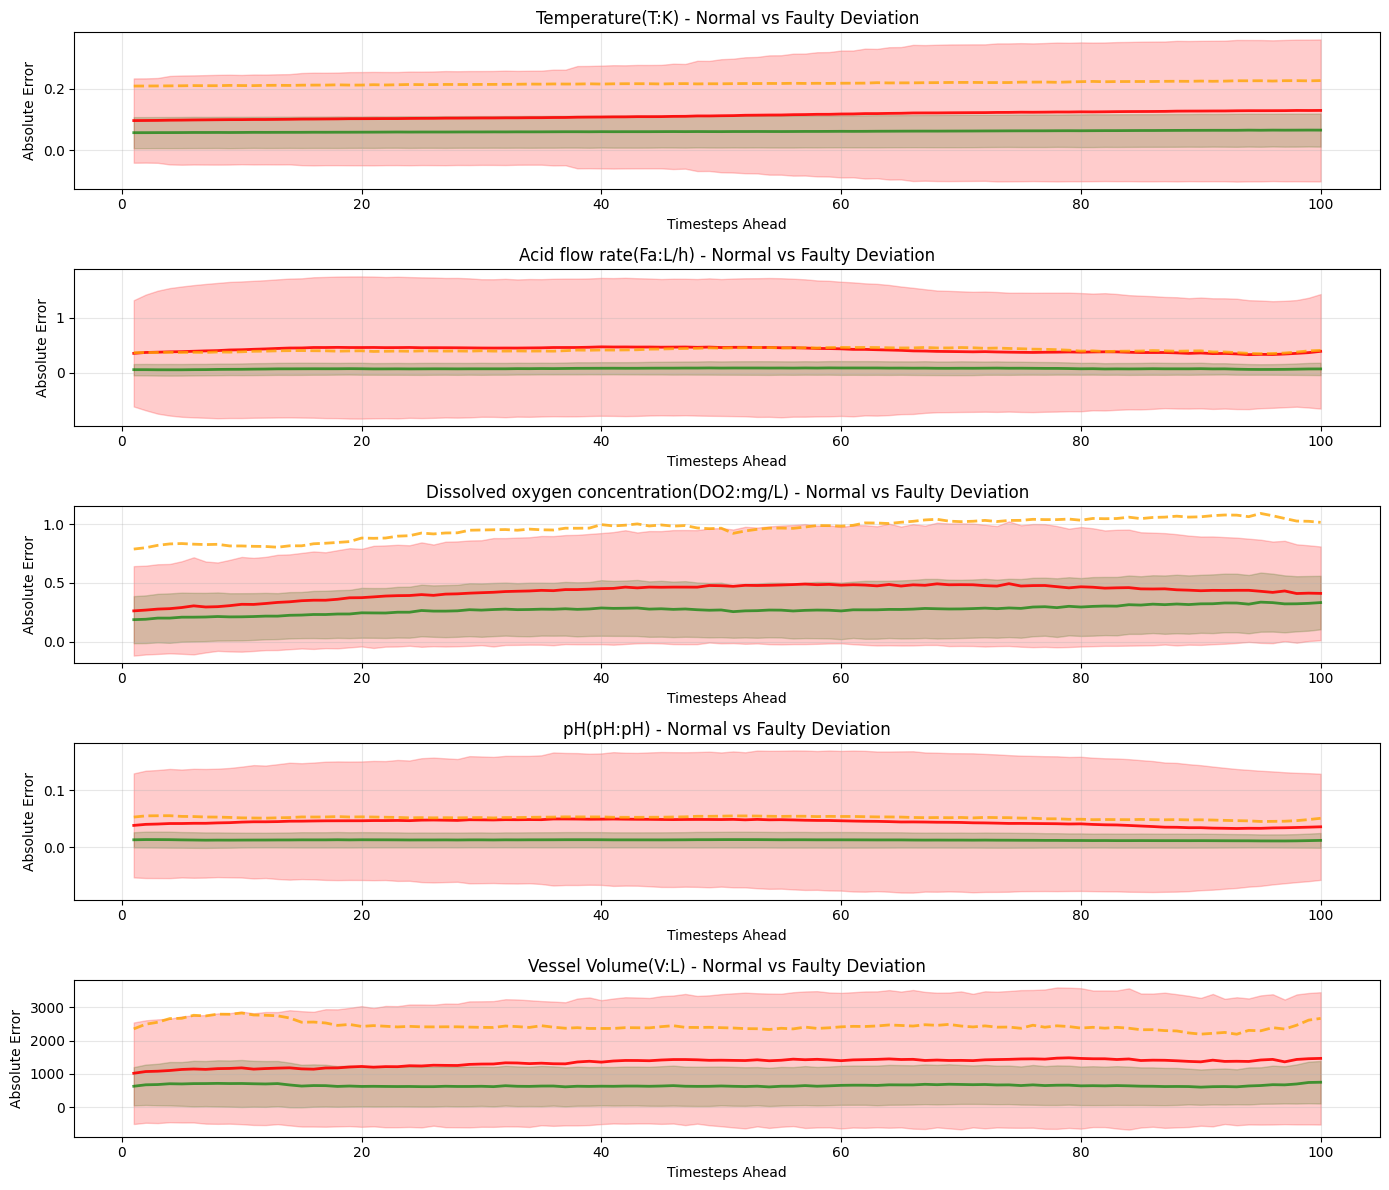

In [13]:

fig, axes = plt.subplots(len(sensors_found), 1, figsize=(14, 12))


normal_errors = np.abs(y_pred - y_test_actual)

for i, sensor_name in enumerate(sensors_found):
    ax = axes[i]
    

    normal_mae = np.mean(normal_errors[:, :, i], axis=0)
    normal_std = np.std(normal_errors[:, :, i], axis=0)
    
   
    faulty_mae = np.mean(anomaly_scores[:, :, i], axis=0)
    faulty_std = np.std(anomaly_scores[:, :, i], axis=0)
    
    timesteps = range(1, future_steps + 1)
    
    
    ax.plot(timesteps, normal_mae, linewidth=2, color='green', 
            label='Normal Batches (Prediction Error)', alpha=0.7)
    ax.fill_between(timesteps, 
                     normal_mae - normal_std, 
                     normal_mae + normal_std, 
                     alpha=0.2, color='green')
    
    
    ax.plot(timesteps, faulty_mae, linewidth=2, color='red', 
            label='Faulty Batches (Anomaly Score)', alpha=0.9)
    ax.fill_between(timesteps, 
                     faulty_mae - faulty_std, 
                     faulty_mae + faulty_std, 
                     alpha=0.2, color='red')
    
    
    threshold = normal_mae + 3 * normal_std
    ax.plot(timesteps, threshold, linewidth=2, linestyle='--', 
            color='orange', label='Anomaly Threshold (3σ)', alpha=0.8)
    
    ax.set_xlabel('Timesteps Ahead')
    ax.set_ylabel('Absolute Error')
    ax.set_title(f'{sensor_name} - Normal vs Faulty Deviation')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("Process Diagnostics")

for i, sensor_name in enumerate(sensors_found):
    normal_mae = np.mean(normal_errors[:, :, i], axis=0)
    normal_std = np.std(normal_errors[:, :, i], axis=0)
    threshold = normal_mae + 3 * normal_std
    
    detection_times = []
    for seq_idx in range(len(anomaly_scores)):
        seq_anomalies = anomaly_scores[seq_idx, :, i]
        exceeds = np.where(seq_anomalies > threshold)[0]
        if len(exceeds) > 0:
            detection_times.append(exceeds[0] + 1)
    
    if len(detection_times) > 0:
        avg_detection = np.mean(detection_times)
        detection_rate = len(detection_times) / len(anomaly_scores) * 100
        
        print(f"\n{sensor_name}:")
        print(f"  Detectable at: {avg_detection:.1f} timesteps ahead")
        print(f"  Detection reliability: {detection_rate:.1f}%")
        print(f"  Avg deviation: {np.mean(anomaly_scores[:, :, i]):.3f}")
        
        if avg_detection < future_steps / 3:
            print(f"  Priority: CRITICAL - Early warning sensor")
        elif detection_rate > 80:
            print(f"  Priority: HIGH - Reliable indicator")
        else:
            print(f"  Priority: SECONDARY - Less consistent")
    else:
        print(f"\n{sensor_name}: Weak indicator")

Process Diagnostics

Temperature(T:K):
  Detectable at: 19.9 timesteps ahead
  Detection reliability: 78.2%
  Avg deviation: 0.113
  Priority: CRITICAL - Early warning sensor

Acid flow rate(Fa:L/h):
  Detectable at: 35.0 timesteps ahead
  Detection reliability: 88.9%
  Avg deviation: 0.419
  Priority: HIGH - Reliable indicator

Dissolved oxygen concentration(DO2:mg/L):
  Detectable at: 28.7 timesteps ahead
  Detection reliability: 36.7%
  Avg deviation: 0.426
  Priority: CRITICAL - Early warning sensor

pH(pH:pH):
  Detectable at: 37.0 timesteps ahead
  Detection reliability: 86.4%
  Avg deviation: 0.044
  Priority: HIGH - Reliable indicator

Vessel Volume(V:L):
  Detectable at: 34.9 timesteps ahead
  Detection reliability: 48.8%
  Avg deviation: 1340.405
  Priority: SECONDARY - Less consistent


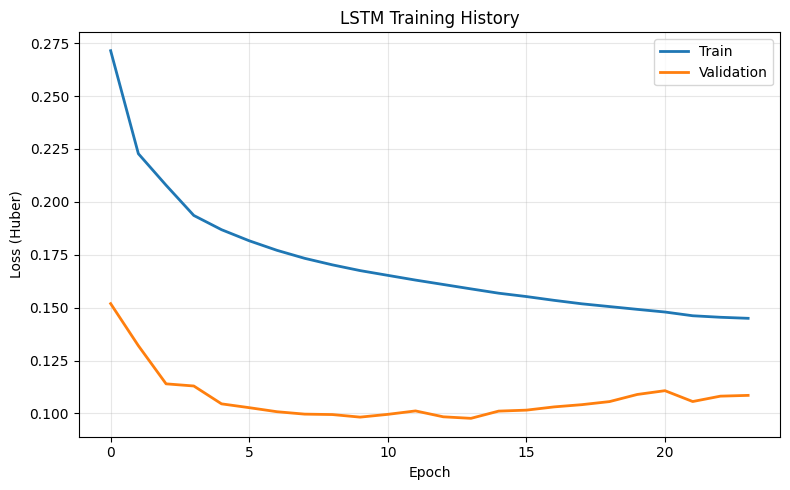

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('LSTM Training History')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

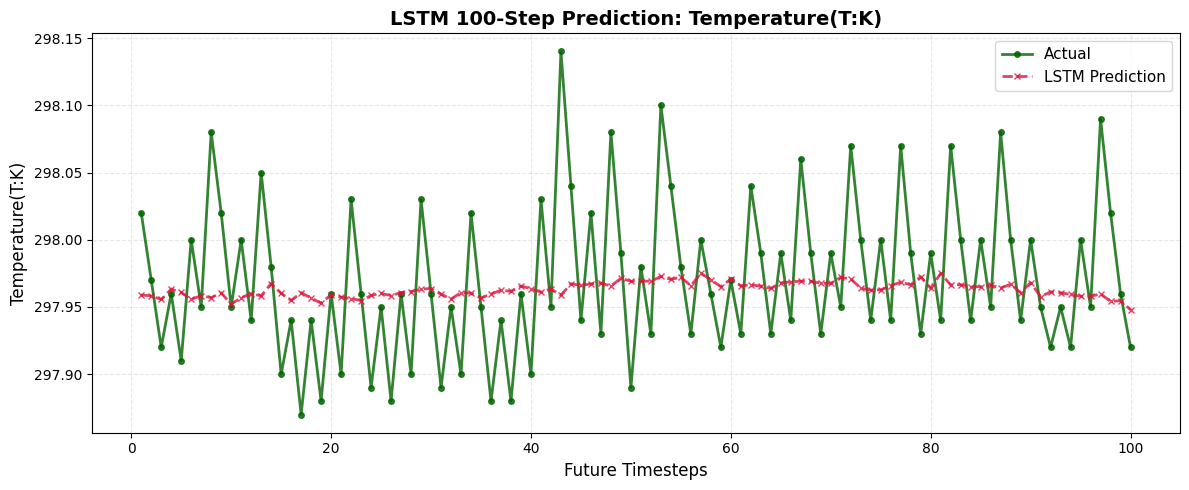

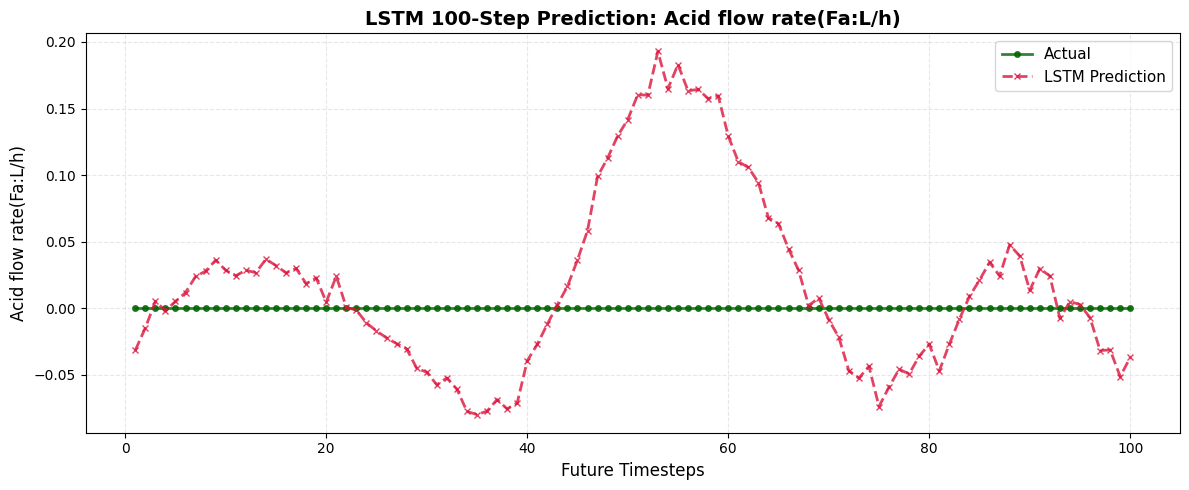

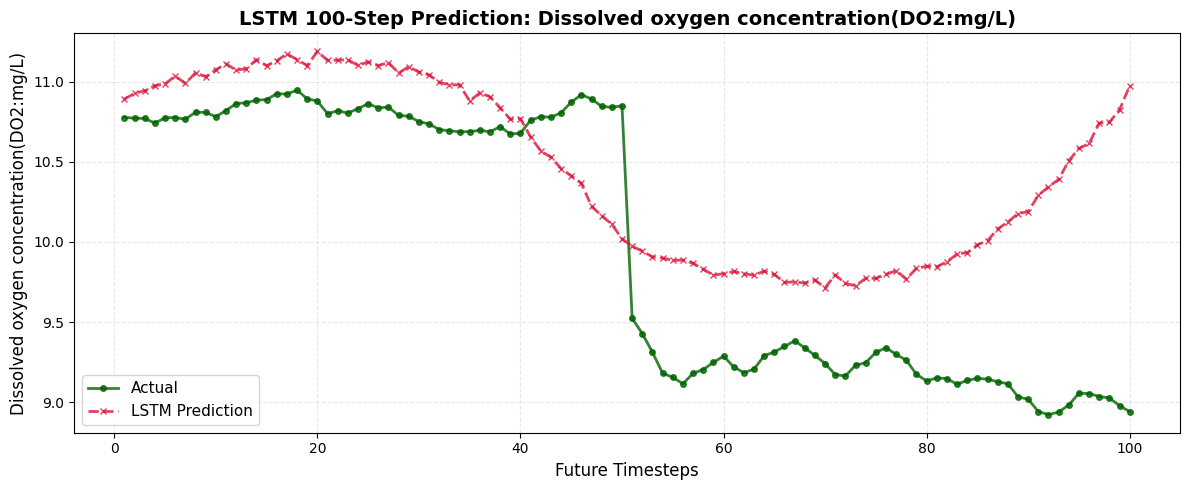

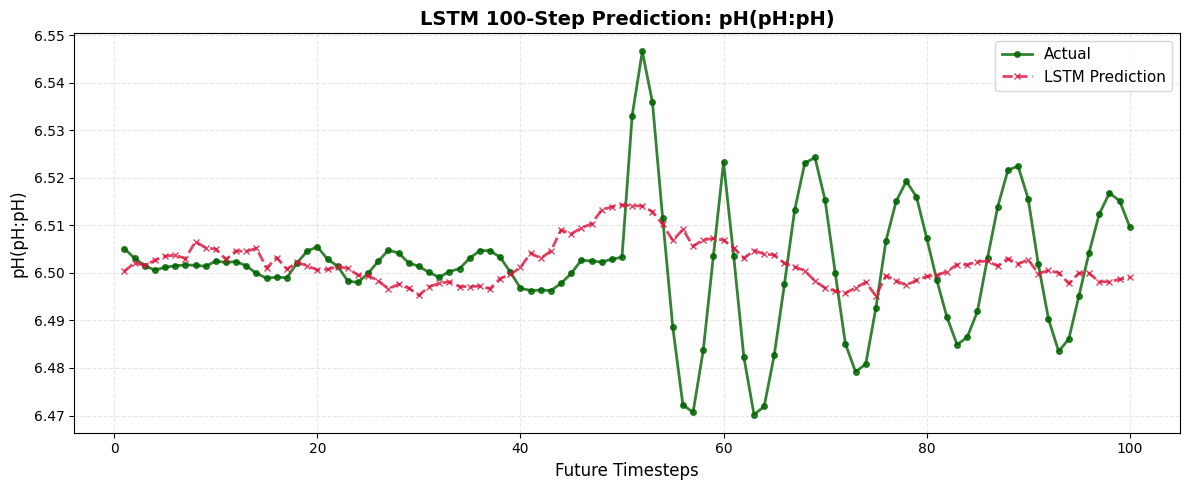

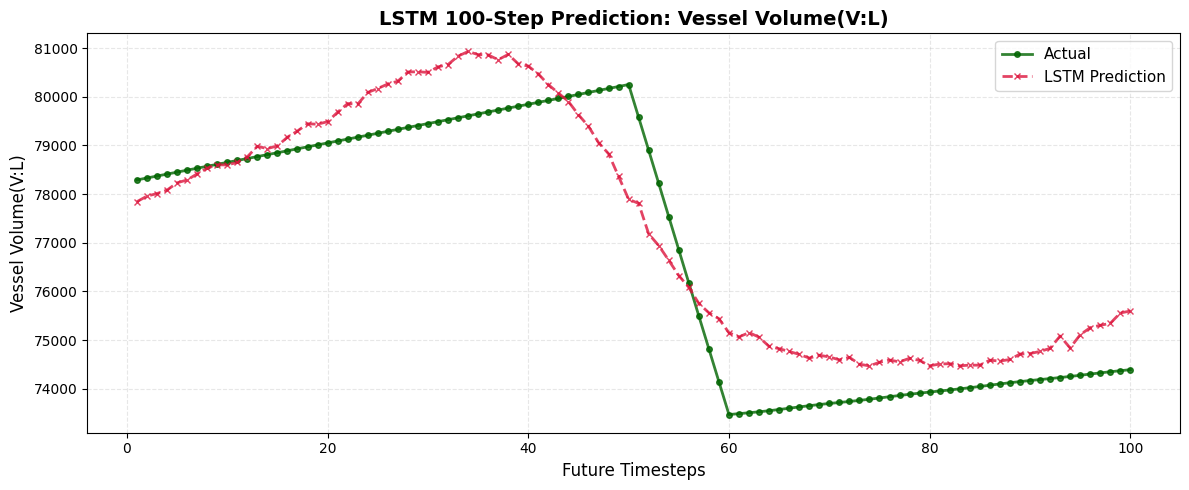

In [16]:

sample_idx = 0  

for i, sensor_name in enumerate(sensors_found):
    plt.figure(figsize=(12, 5))
    
    timesteps = range(1, future_steps + 1)
    
    plt.plot(timesteps, y_test_actual[sample_idx, :, i], 
             marker='o', markersize=4, label='Actual', linewidth=2, 
             color='darkgreen', alpha=0.8)
    plt.plot(timesteps, y_pred[sample_idx, :, i], 
             marker='x', markersize=4, label='LSTM Prediction', linewidth=2, 
             color='crimson', alpha=0.8, linestyle='--')
    
    plt.xlabel('Future Timesteps', fontsize=12)
    plt.ylabel(f'{sensor_name}', fontsize=12)
    plt.title(f'LSTM 100-Step Prediction: {sensor_name}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    plt.show()


Normal batches: 90, Faulty batches: 10
Anomaly threshold calibration (NORMAL VAL):
  Score mode: max_time_mean_sensors

  Threshold @ 99th percentile (normal-val): 1.327916
  False alarm rate on NORMAL test (FPR): 0.000%
  Detection rate on FAULTY post-fault (TPR): 77.793%
  Miss rate on FAULTY post-fault (FNR): 22.207%

  Threshold @ 97.5th percentile (normal-val): 1.169732
  False alarm rate on NORMAL test (FPR): 1.261%
  Detection rate on FAULTY post-fault (TPR): 80.509%
  Miss rate on FAULTY post-fault (FNR): 19.491%

  Threshold @ 95th percentile (normal-val): 1.078534
  False alarm rate on NORMAL test (FPR): 3.303%
  Detection rate on FAULTY post-fault (TPR): 81.386%
  Miss rate on FAULTY post-fault (FNR): 18.614%

  Threshold @ 92.5th percentile (normal-val): 0.994697
  False alarm rate on NORMAL test (FPR): 4.925%
  Detection rate on FAULTY post-fault (TPR): 82.178%
  Miss rate on FAULTY post-fault (FNR): 17.822%

  Threshold @ 90th percentile (normal-val): 0.950339
  False ala

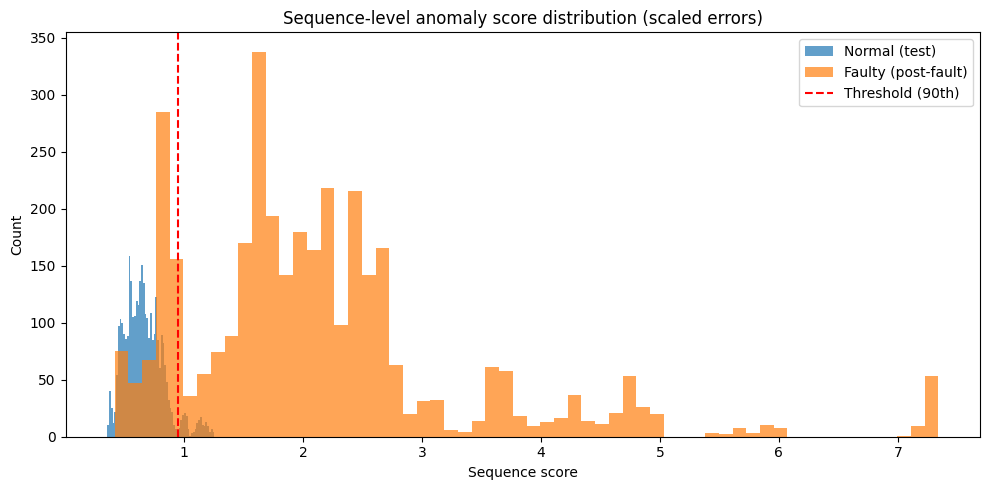

In [17]:
def seq_score(abs_err, mode="max_time_mean_sensors"):
    if mode == "mean":
        return abs_err.mean(axis=(1, 2))
    if mode == "max_time_mean_sensors":
        return abs_err.mean(axis=2).max(axis=1)
    if mode == "max":
        return abs_err.max(axis=(1, 2))
    if mode == "top1pct":
        flat = abs_err.reshape(abs_err.shape[0], -1)
        k = max(1, int(0.01 * flat.shape[1]))
        topk = np.partition(flat, -k, axis=1)[:, -k:]
        return topk.mean(axis=1)
    raise ValueError("Unknown mode")

# validation scores
y_val_pred_scaled = model.predict(X_val, verbose=0)
abs_err_val = np.abs(y_val_pred_scaled - y_val)

# FPR

abs_err_test = np.abs(y_pred_scaled - y_test)

# TPR estimate
X_all, y_all, batch_ids_all, seq_labels_all = create_multi_step_sequences(
    df, fault_info, seq_length, future_steps,
    normal_only=False, fault_flag_col="Fault flag", label_on="future"
)
if seq_labels_all is None:
    raise ValueError("Fault flag column not found; cannot compute post-fault TPR.")

faulty_batch_set = set(fault_info.keys())
faulty_mask = np.isin(batch_ids_all, list(faulty_batch_set)) & (seq_labels_all == 1)

X_faulty = X_all[faulty_mask]
y_faulty = y_all[faulty_mask]

X_faulty_scaled = scaler_X.transform(X_faulty.reshape(-1, len(sensors_found))).reshape(len(X_faulty), seq_length, len(sensors_found))
y_faulty_scaled = scaler_y.transform(y_faulty.reshape(-1, len(sensors_found))).reshape(len(y_faulty), future_steps, len(sensors_found))

y_pred_faulty_scaled = model.predict(X_faulty_scaled, verbose=0)
abs_err_faulty = np.abs(y_pred_faulty_scaled - y_faulty_scaled)

mode = "max_time_mean_sensors"
normal_val_score = seq_score(abs_err_val, mode=mode)
normal_test_score = seq_score(abs_err_test, mode=mode)
faulty_score = seq_score(abs_err_faulty, mode=mode)

print("Anomaly threshold calibration (NORMAL VAL):")
print(f"  Score mode: {mode}")

for pct in [99, 97.5, 95, 92.5, 90, 85, 80]:
    threshold = np.percentile(normal_val_score, pct)
    fpr = (normal_test_score > threshold).mean()
    tpr = (faulty_score > threshold).mean()
    fnr = 1.0 - tpr

    print(f"\n  Threshold @ {pct}th percentile (normal-val): {threshold:.6f}")
    print(f"  False alarm rate on NORMAL test (FPR): {fpr:.3%}")
    print(f"  Detection rate on FAULTY post-fault (TPR): {tpr:.3%}")
    print(f"  Miss rate on FAULTY post-fault (FNR): {fnr:.3%}")


plot_pct = 90
plot_threshold = np.percentile(normal_val_score, plot_pct)

plt.figure(figsize=(10, 5))
plt.hist(normal_test_score, bins=60, alpha=0.7, label="Normal (test)")
plt.hist(faulty_score, bins=60, alpha=0.7, label="Faulty (post-fault)")
plt.axvline(plot_threshold, color="red", linestyle="--", label=f"Threshold ({plot_pct}th)")
plt.title("Sequence-level anomaly score distribution (scaled errors)")
plt.xlabel("Sequence score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

